# Next 16-days Temp, Rainfall, humidity, wind, alerts

In [1]:
district = "LUCKNOW"

In [2]:
import os
import requests
import numpy as np
import pandas as pd

OWM_API_KEY = "b93651e4ede9b7679f28a549efcae210"  # replace with your OpenWeather key

def get_coords(district, limit=5):
    """
    Returns (lat, lon) for a district using OpenWeather's direct geocoding API.
    Uses only the district name in the query.
    """
    url = "http://api.openweathermap.org/geo/1.0/direct"
    params = {
        "q": district,   # ✅ only district name
        "limit": limit,
        "appid": OWM_API_KEY,
    }
    resp = requests.get(url, params=params, timeout=15)
    resp.raise_for_status()
    results = resp.json()

    if not results:
        raise ValueError(f"No coordinates found for '{district}'")

    return results[0]["lat"], results[0]["lon"]


lat, lon = get_coords(district)
print({"lat": lat, "lon": lon})


# === Open-Meteo API Calls ===
url1 = (
    "https://api.open-meteo.com/v1/forecast"
    f"?latitude={lat}&longitude={lon}"
    "&daily=temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_gusts_10m_max"
    "&timezone=Asia/Kolkata"
    "&forecast_days=16"
)

url2 = (
    "https://api.open-meteo.com/v1/forecast"
    f"?latitude={lat}&longitude={lon}"
    "&hourly=relative_humidity_2m"
    "&timezone=Asia/Kolkata"
    "&forecast_days=16"
)

resp = requests.get(url1, timeout=15)
resp.raise_for_status()
data = resp.json()

resp2 = requests.get(url2, timeout=15)
resp2.raise_for_status()
data2 = resp2.json()

# === Validation for required fields ===
required_daily_keys = ["time", "temperature_2m_max", "temperature_2m_min", "precipitation_sum", "wind_speed_10m_max", "wind_gusts_10m_max"]
for key in required_daily_keys:
    if key not in data.get("daily", {}):
        raise KeyError(f"Missing key '{key}' in Open-Meteo daily response")

if "time" not in data2.get("hourly", {}) or "relative_humidity_2m" not in data2.get("hourly", {}):
    raise KeyError("Missing humidity data in Open-Meteo hourly response")


# === Build DataFrames ===
df = pd.DataFrame({
    'date': data['daily']['time'],
    'temp_max': data['daily']['temperature_2m_max'],
    'temp_min': data['daily']['temperature_2m_min'],
    'precip_mm': data['daily']['precipitation_sum'],
    'wind_speed': data['daily']['wind_speed_10m_max'],
    'wind_gusts': data['daily']['wind_gusts_10m_max'],
})

df2 = pd.DataFrame({
    'date': data2['hourly']['time'],
    'humidity': data2['hourly']['relative_humidity_2m']
})

# Convert hourly → daily avg humidity
df2["date"] = pd.to_datetime(df2["date"]).dt.strftime("%Y-%m-%d")
humidity_daily = (
    df2.groupby("date", as_index=False)["humidity"].mean()
    .rename(columns={"humidity": "humidity_mean"})
)

df = df.merge(
    humidity_daily.rename(columns={"humidity_mean": "humidity"}),
    on="date",
    how="left"
)

# === Averages (16-day) ===
avg_prec_16d = float(df["precip_mm"].mean())
avg_temp_max_16d = float(df["temp_max"].mean())
avg_temp_min_16d = float(df["temp_min"].mean())
avg_humidity_16d = float(df["humidity"].mean())
avg_wind_s_16d = float(df["wind_speed"].mean())
avg_wind_g_16d = float(df["wind_gusts"].mean())

print(f"Avg precipitation (16 days): {avg_prec_16d:.2f} mm")
print(f"Avg temperature Min (16 days): {avg_temp_min_16d:.2f} °C")
print(f"Avg temperature Max (16 days): {avg_temp_max_16d:.2f} °C")
print(f"Avg humidity (16 days): {avg_humidity_16d:.2f} %")
print(f"Avg wind speed (16 days): {avg_wind_s_16d:.2f} m/s")
print(f"Avg wind gusts (16 days): {avg_wind_g_16d:.2f} m/s")

# === Final Input Dict ===
try:
    inputt
except NameError:
    inputt = {}

inputt.update({
    "temperature_max": avg_temp_max_16d,
    "temperature_min": avg_temp_min_16d,
    "humidity": avg_humidity_16d,
    "rainfall": avg_prec_16d,
    "wind_speed": avg_wind_s_16d,
    "wind_gusts": avg_wind_g_16d
})

# Example array for ML model input
val_arr = np.array(list(inputt.values()), dtype=float)
df["temp"] = (df["temp_min"] + df["temp_max"]) / 2



{'lat': 26.8381, 'lon': 80.9346001}
Avg precipitation (16 days): 6.54 mm
Avg temperature Min (16 days): 25.52 °C
Avg temperature Max (16 days): 30.60 °C
Avg humidity (16 days): 84.61 %
Avg wind speed (16 days): 14.35 m/s
Avg wind gusts (16 days): 30.33 m/s


In [3]:
df

,date,temp_max,temp_min,precip_mm,wind_speed,wind_gusts,humidity,temp
0,2025-08-22,31.1,25.9,19.3,6.9,20.9,88.708333,28.50
1,2025-08-23,31.0,25.7,8.7,12.6,37.4,86.583333,28.35
2,2025-08-24,27.3,25.5,16.2,9.2,23.4,92.875000,26.40
3,2025-08-25,30.4,25.1,13.4,7.6,25.2,88.583333,27.75
4,2025-08-26,31.3,25.6,6.9,11.3,34.6,84.708333,28.45
5,2025-08-27,33.1,25.8,0.9,9.0,31.7,80.750000,29.45
6,2025-08-28,31.8,26.3,1.2,7.8,22.3,81.500000,29.05
7,2025-08-29,30.8,26.5,6.3,17.3,42.5,84.083333,28.65
8,2025-08-30,33.0,26.3,0.0,24.4,43.2,72.833333,29.65
9,2025-08-31,32.9,26.2,5.1,18.6,26.3,74.458333,29.55


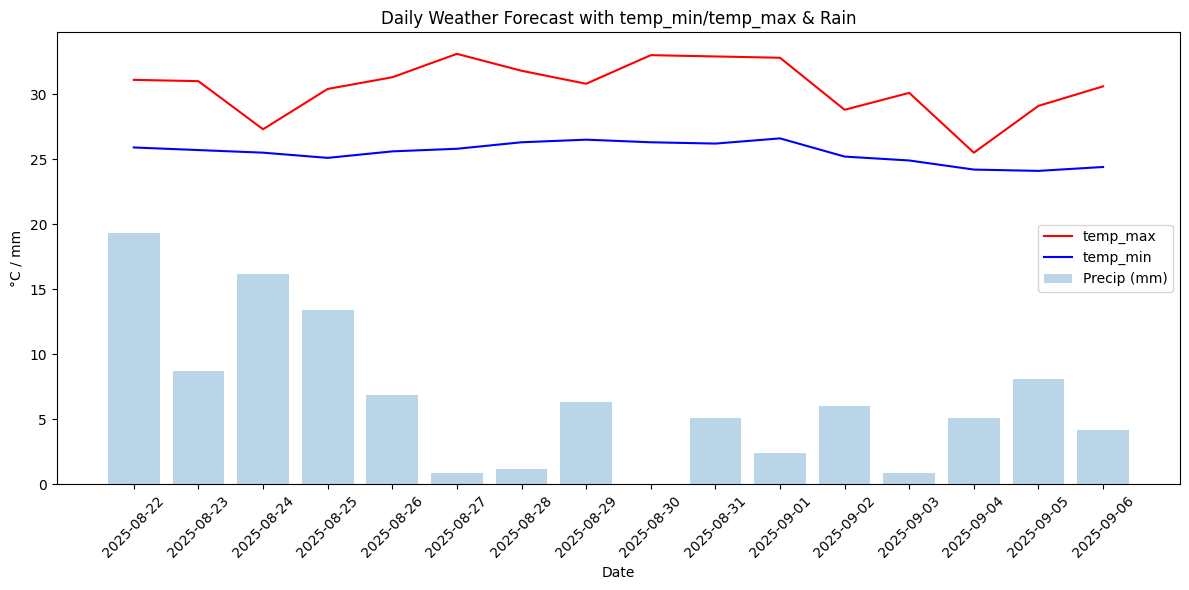

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json


# 2. Derived Weather Features

# Daily Temperature Range
df["dtr"] = df["temp_max"] - df["temp_min"]

# Heat Index (simplified)
df["heat_index"] = df["temp"] + 0.33*df["humidity"]/100*6.105*np.exp(17.27*df["temp"]/(237.7+df["temp"])) - 4

# Wind Chill (valid when temp < 10°C)
df["wind_chill"] = np.where(
    (df["temp"] < 10) & (df["wind_speed"] > 4.8),
    13.12 + 0.6215*df["temp"] - 11.37*(df["wind_speed"]**0.16) + 0.3965*df["temp"]*(df["wind_speed"]**0.16),
    np.nan
)

# Wind Risk Index
df["wind_risk"] = df["wind_gusts"] / (df["wind_speed"] + 1)

# Approx Evapotranspiration (ET0) using Hargreaves (simplified)
df["et0"] = 0.0023 * (df["temp_max"] - df["temp_min"])**0.5 * (df["temp"] + 17.8)

# Aridity Index (precipitation vs ET)
df["aridity_index"] = df["precip_mm"] / (df["et0"] + 0.01)

# ==============================
# 3. Crop Stress Flags
# ==============================

def classify_flags(row):
    flags = {}

    # Heat Stress
    if row["temp_max"] > 38:
        flags["heat"] = "🔴 Red (Heat stress)"
    elif row["temp_max"] > 32:
        flags["heat"] = "🟡 Yellow (Mild stress)"
    else:
        flags["heat"] = "🟢 Green (Safe)"

    # Cold Stress
    if row["temp_min"] < 5:
        flags["cold"] = "🔴 Red (Frost risk)"
    elif row["temp_min"] < 10:
        flags["cold"] = "🟡 Yellow (Chill stress)"
    else:
        flags["cold"] = "🟢 Green (Safe)"

    # Drought/Irrigation Need
    if row["aridity_index"] < 0.5:
        flags["water"] = "🔴 Red (Irrigation needed)"
    elif row["aridity_index"] < 1:
        flags["water"] = "🟡 Yellow (Monitor)"
    else:
        flags["water"] = "🟢 Green (Sufficient)"

    # Wind Damage
    if row["wind_gusts"] > 60:
        flags["wind"] = "🔴 Red (Lodging risk)"
    elif row["wind_gusts"] > 40:
        flags["wind"] = "🟡 Yellow (Caution)"
    else:
        flags["wind"] = "🟢 Green (Safe)"

    return flags

df["flags"] = df.apply(classify_flags, axis=1)

# ==============================
# 4. Crop Recommendations
# ==============================

# === Load the knowledge base (once at the top) ===
with open("crop_knowledgebase.json", "r", encoding="utf-8") as f:
    KB = json.load(f)

# Map crop name -> rules for fast lookup
CROP_RULES = {c["name"]: c["rules"] for c in KB["crops"]}
# Also add aliases
for c in KB["crops"]:
    for alias in c.get("aliases", []):
        CROP_RULES[alias] = c["rules"]

# === Dynamic crop-specific recommendation ===
def crop_recommendation(row, crop_name="rice"):
    recs = []
    rules = CROP_RULES.get(crop_name.lower())

    if not rules:
        return f"No knowledge base found for crop '{crop_name}'."

    for rule in rules:
        # Evaluate the condition in a safe namespace
        try:
            if eval(rule["when"], {}, row.to_dict()):
                recs.append(f"[{rule['severity'].upper()}] {rule['advisory']}")
        except Exception as e:
            continue  # skip faulty rule

    if not recs:
        recs.append("Conditions favorable — proceed with normal farming.")

    return " | ".join(recs)

# Example: apply for rice
df["recommendations"] = df.apply(lambda row: crop_recommendation(row, crop_name="rice"), axis=1)


# ==============================
# 5. Visualization Example
# ==============================

plt.figure(figsize=(12,6))
plt.plot(df["date"], df["temp_max"], label="temp_max", color="red")
plt.plot(df["date"], df["temp_min"], label="temp_min", color="blue")
plt.bar(df["date"], df["precip_mm"], label="Precip (mm)", alpha=0.3)
plt.legend()
plt.title("Daily Weather Forecast with temp_min/temp_max & Rain")
plt.xlabel("Date")
plt.ylabel("°C / mm")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ==============================
# 6. Save Final Output
# ==============================
df.to_csv("weather_agri_pipeline.csv", index=False)


In [12]:
df["recommendations"]

0     [HIGH] High heat can cause spikelet sterility ...
1     [HIGH] High heat can cause spikelet sterility ...
2     Conditions favorable — proceed with normal far...
3     Conditions favorable — proceed with normal far...
4     [HIGH] High heat can cause spikelet sterility ...
5     [HIGH] High heat can cause spikelet sterility ...
6     [HIGH] High heat can cause spikelet sterility ...
7     [HIGH] High heat can cause spikelet sterility ...
8     [HIGH] High heat can cause spikelet sterility ...
9     [HIGH] High heat can cause spikelet sterility ...
10    [HIGH] High heat can cause spikelet sterility ...
11    Conditions favorable — proceed with normal far...
12    Conditions favorable — proceed with normal far...
13    Conditions favorable — proceed with normal far...
14    Conditions favorable — proceed with normal far...
15    Conditions favorable — proceed with normal far...
Name: recommendations, dtype: object